<a href="https://colab.research.google.com/github/Aarya-Mandvilkar/exercise_evaluator/blob/main/Exercise_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finding Pose Coordinates with MediaPipe

## Setup

Make sure you upload your video file into files

In [ ]:
# Installing MediaPipe
!pip install -q mediapipe==0.10.0
!wget -O pose_landmarker.task -q https://storage.googleapis.com/mediapipe-models/pose_landmarker/pose_landmarker_heavy/float16/1/pose_landmarker_heavy.task

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 16.9 MB/s eta 0:00:00


In [ ]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

## Get Frames

In [ ]:
# upload video file from https://www.kaggle.com/datasets/hasyimabdillah/workoutfitness-video
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving push-up_1.mp4 to push-up_1 (1).mp4


In [ ]:
import cv2
# getting video
video = cv2.VideoCapture(filename)

In [ ]:
from IPython.display import HTML
from base64 import b64encode

# displaying video
print("Your video:\n")
mp4 = open(filename,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Your video:



your starting frame:



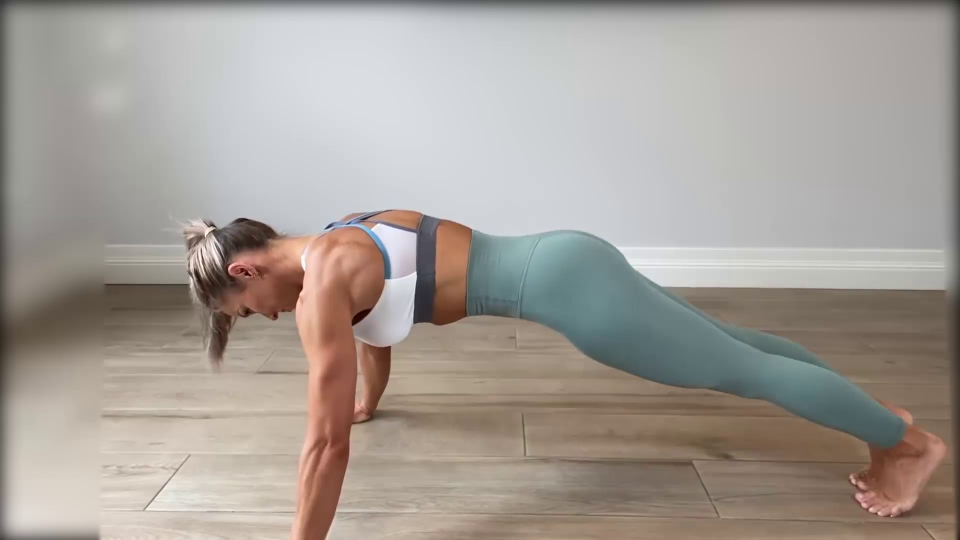



your ending frame:



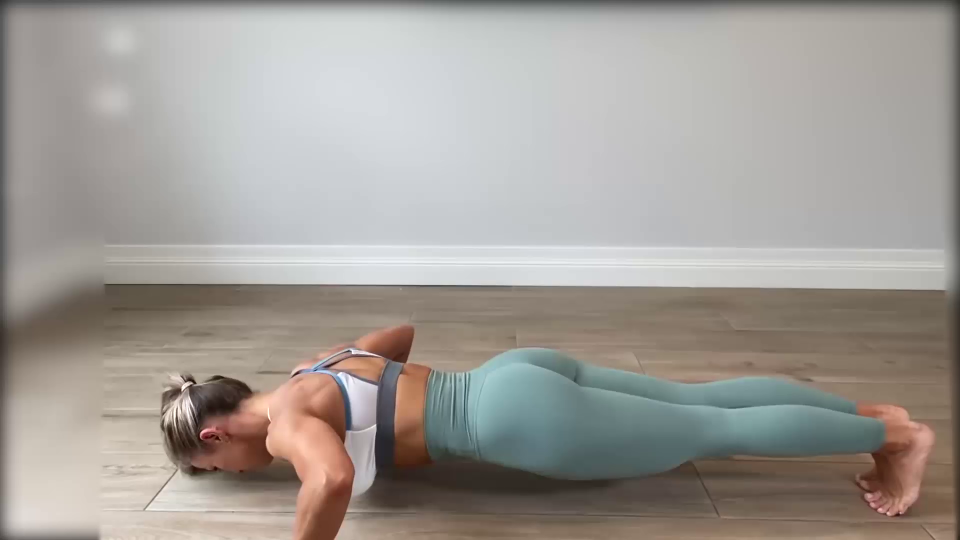

In [ ]:
#@markdown enter the frame of your starting pose you would like to choose based on the time stamp in the video
from google.colab.patches import cv2_imshow
start_minutes = 0 # @param {type: "integer"}
start_seconds = 0 # @param {type: "integer"}

# getting frame from time stamp of video
start_t_msec = 1000 * (start_minutes * 60 + start_seconds)
video.set(cv2.CAP_PROP_POS_MSEC, start_t_msec)
start_ret, start_frame = video.read()

start_frame = cv2.resize(start_frame, (0, 0), fx = 0.5, fy = 0.5)

# displaying starting frames
print("your starting frame:\n")
cv2_imshow(start_frame)

#@markdown enter the frame of your ending pose that you would like to choose based on the time stamp in the video
from google.colab.patches import cv2_imshow
end_minutes = 0 # @param {type: "integer"}
end_seconds = 1 # @param {type: "integer"}

# getting frame from time stamp of video
end_t_msec = 1000 * (end_minutes * 60 + end_seconds)
video.set(cv2.CAP_PROP_POS_MSEC, end_t_msec)
end_ret, end_frame = video.read()
end_frame = cv2.resize(end_frame, (0, 0), fx = 0.5, fy = 0.5)

# displaying ending frame
print("\n\nyour ending frame:\n")
cv2_imshow(end_frame)

In [ ]:
cv2.imwrite('start_frame.jpg', start_frame)
cv2.imwrite('end_frame.jpg', end_frame)

True

## Detecting Starting Pose

starting frame:



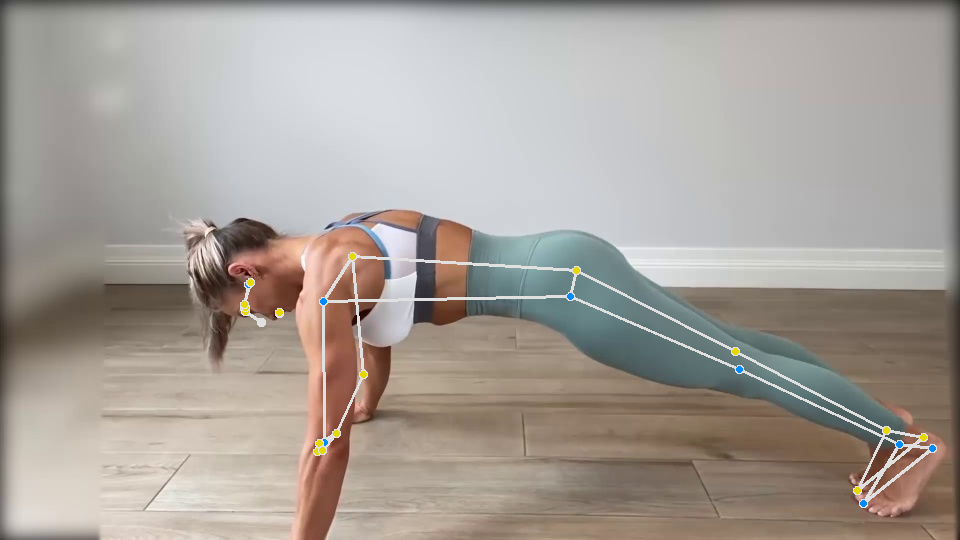

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as start_mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = start_mp.Image.create_from_file("start_frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print("starting frame:\n")
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

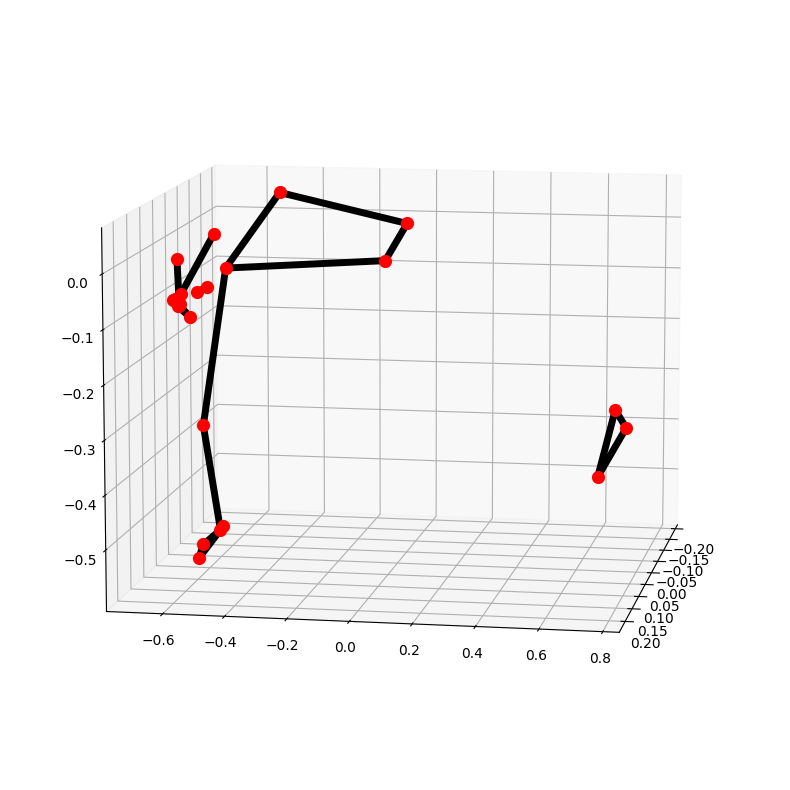

In [ ]:
# For static images:
start_mp_drawing = start_mp.solutions.drawing_utils
start_mp_drawing_styles = start_mp.solutions.drawing_styles
start_mp_pose = start_mp.solutions.pose
BG_COLOR = (192, 192, 192) # gray
with start_mp_pose.Pose(
    static_image_mode = True,
    model_complexity = 2,
    enable_segmentation = True,
    min_detection_confidence = 0.5) as pose:

  image = cv2.imread("start_frame.jpg")
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  start_results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  annotated_image_start = image.copy()
  # Draw segmentation on the image.
  # To improve segmentation around boundaries, consider applying a joint
  # bilateral filter to "results.segmentation_mask" with "image".
  condition = np.stack((start_results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR
  annotated_image_start = np.where(condition, annotated_image_start, bg_image)

  # Draw pose landmarks on the image.
  start_mp_drawing.draw_landmarks(
      annotated_image_start,
      start_results.pose_landmarks,
      start_mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec = start_mp_drawing_styles.get_default_pose_landmarks_style())
  cv2.imwrite('/tmp/annotated_image_start.jpg', annotated_image_start)

  # cv2_imshow(annotated_image_start)

  # Plot pose world landmarks.
  start_mp_drawing.plot_landmarks(
      start_results.pose_world_landmarks, start_mp_pose.POSE_CONNECTIONS)

## Detecting Ending Pose

ending frame:



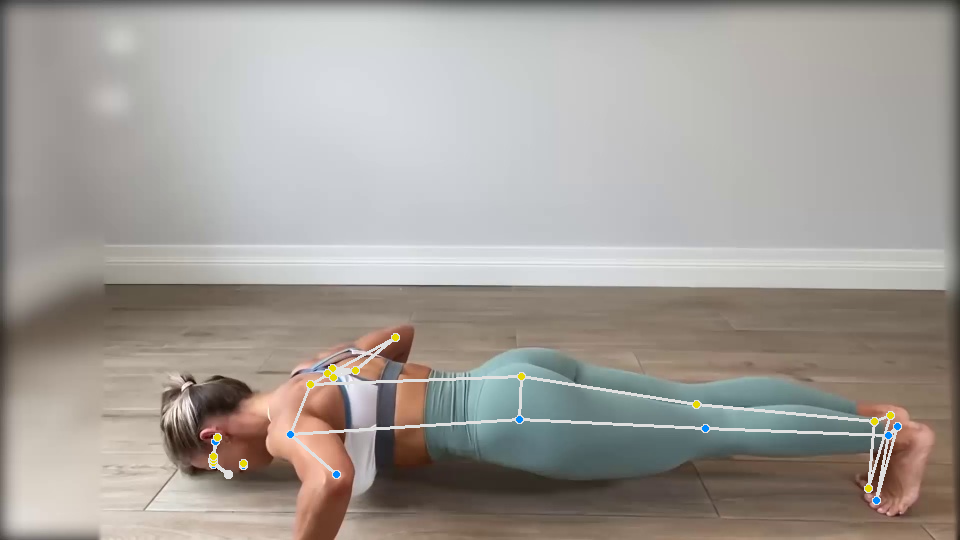

In [ ]:
# STEP 1: Import the necessary modules.
import mediapipe as end_mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an PoseLandmarker object.
base_options = python.BaseOptions(model_asset_path='pose_landmarker.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)

# STEP 3: Load the input image.
image = end_mp.Image.create_from_file("end_frame.jpg")

# STEP 4: Detect pose landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
print("ending frame:\n")
cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))


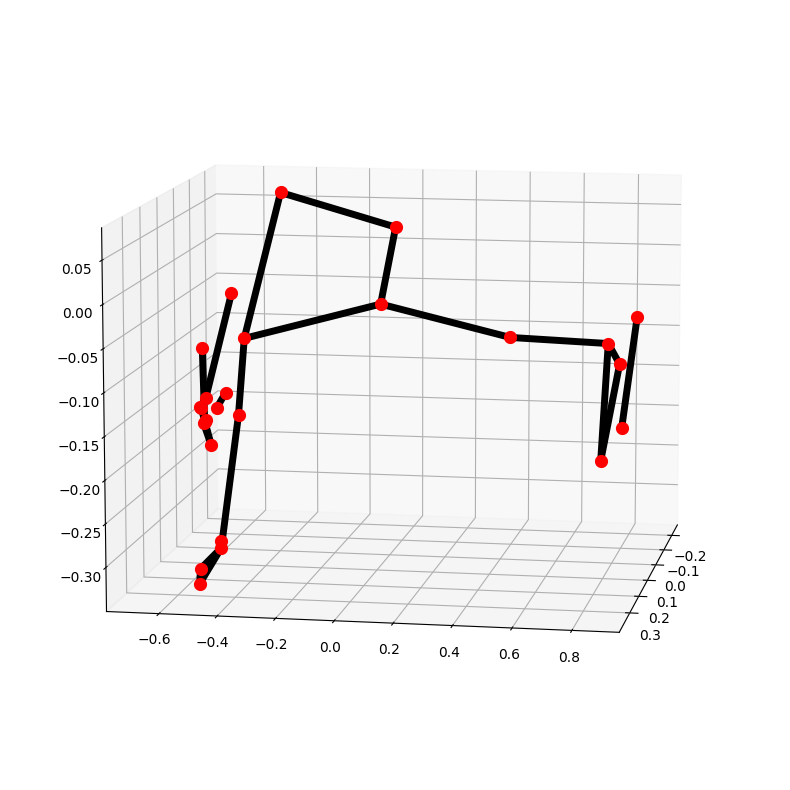

In [ ]:
# For static images:
end_mp_drawing = end_mp.solutions.drawing_utils
end_mp_drawing_styles = end_mp.solutions.drawing_styles
end_mp_pose = end_mp.solutions.pose
BG_COLOR = (192, 192, 192) # gray
with end_mp_pose.Pose(
    static_image_mode = True,
    model_complexity = 2,
    enable_segmentation = True,
    min_detection_confidence = 0.5) as pose:

  image = cv2.imread("end_frame.jpg")
  image_height, image_width, _ = image.shape
  # Convert the BGR image to RGB before processing.
  end_results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

  annotated_image = image.copy()
  # Draw segmentation on the image.
  # To improve segmentation around boundaries, consider applying a joint
  # bilateral filter to "results.segmentation_mask" with "image".
  condition = np.stack((end_results.segmentation_mask,) * 3, axis=-1) > 0.1
  bg_image = np.zeros(image.shape, dtype=np.uint8)
  bg_image[:] = BG_COLOR
  annotated_image = np.where(condition, annotated_image, bg_image)

  # Draw pose landmarks on the image.
  end_mp_drawing.draw_landmarks(
      annotated_image,
      end_results.pose_landmarks,
      end_mp_pose.POSE_CONNECTIONS,
      landmark_drawing_spec = end_mp_drawing_styles.get_default_pose_landmarks_style())
  cv2.imwrite('/tmp/annotated_image_end.jpg', annotated_image)

  # Plot pose world landmarks.
  end_mp_drawing.plot_landmarks(
      end_results.pose_world_landmarks, end_mp_pose.POSE_CONNECTIONS)

## Finding Coordinates

In [ ]:
start_frame_hight, start_frame_width, _ = start_frame.shape
end_frame_hight, end_frame_width, _ = end_frame.shape
# Note: the times 100 might be wrong idk

# scaling factors
x_scale = 100
y_scale = 100
z_scale = 254

# Getting XYZ-coordinates of nose
x1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].x * x_scale
x2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].x * x_scale
y1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].y * y_scale
y2_coordinate = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].y * y_scale
z1_coordinate = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.NOSE].z * z_scale
z2_coordinate = start_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.NOSE].z * z_scale
print("Initial Coordinates of Nose:")
print("x:", x1_coordinate)
print("y:", y1_coordinate)
print("z:", z1_coordinate)

print("\nFinal Coordinates of Nose:")
print("x:", x2_coordinate)
print("y:", y2_coordinate)
print("z:", z2_coordinate)
x_scale, y_scale

Initial Coordinates of Nose:
x: 27.14284658432007
y: 59.55169200897217
z: -0.05735234305029735

Final Coordinates of Nose:
x: 23.92488867044449
y: 87.65625953674316
z: -0.05735234305029735


(100, 100)

In [ ]:
import math
# Finding distance in specified axis (for different parts)
def xyz_distances(part_1, part_2, axis):
  if(axis == 'x'):
    return (part_2.x - part_1.x) * x_scale
  elif(axis == 'y'):
    return (part_2.y - part_1.y) * y_scale
  else:
    return (part_2.z - part_1.z) * z_scale

# Finding distance in specified axis (for same part)
def landmark(start_position, end_position, axis):
  if(axis == 'x'):
    return (end_position.x - start_position.x) * x_scale
  elif(axis == 'y'):
    return (end_position.y - start_position.y) * y_scale
  else:
    return (end_position.z - start_position.z) * z_scale

# Finding 3D distances
def distance_3D(part_1, part_2):
  x = (part_2.x - part_1.x) * x_scale
  y = (part_2.y - part_1.y) * y_scale
  z = (part_2.z - part_1.z) * z_scale
  return math.sqrt(x**2 + y**2 + z**2)

# find angle between 3 landmarks
def angle(part_1, part_2, part_3):
  a_mag = math.sqrt(((part_1.x - part_2.x) * x_scale)**2 + ((part_1.y - part_2.y) * y_scale)**2 + ((part_1.z - part_2.z) * z_scale)**2)
  b_mag = math.sqrt(((part_3.x - part_2.x) * x_scale)**2 + ((part_3.y - part_2.y) * y_scale)**2 + ((part_3.z - part_2.z) * z_scale)**2)
  a_dot_b = ((part_1.x - part_2.x) * (part_3.x - part_2.x) * x_scale**2) + ((part_1.y - part_2.y) * (part_3.y - part_2.y) * y_scale**2) + ((part_1.z - part_2.z) * (part_3.z - part_2.z) * z_scale**2)
  angle = (math.acos(a_dot_b / (a_mag * b_mag))) * (180 / math.pi)
  return angle

def mid_angle(right_knee, left_knee, right_hip, left_hip):
  mid_hip_x = (left_hip.x + right_hip.x)/2.0
  mid_hip_y = (left_hip.y + right_hip.y)/2.0
  mid_hip_z = (left_hip.z + right_hip.z)/2.0

  a_mag = math.sqrt((right_knee.x - mid_hip_x)**2 + (right_knee.y - mid_hip_y)**2 + (right_knee.z - mid_hip_z)**2)
  b_mag = math.sqrt((left_knee.x - mid_hip_x)**2 + (left_knee.y - mid_hip_y)**2 + (left_knee.z - mid_hip_z)**2)
  a_dot_b = ((right_knee.x - mid_hip_x)*(left_knee.x - mid_hip_x)) + ((right_knee.y - mid_hip_y)*(left_knee.y - mid_hip_y)) + ((right_knee.z - mid_hip_z)*(left_knee.z - mid_hip_z))
  angle = (math.acos(a_dot_b / (a_mag * b_mag))) * (180 / math.pi)
  return angle

def distance_3D_avg(part_1, part_2a, part_2b):
  x = (((part_2a.x + part_2b.x)/2) - part_1.x) * x_scale
  y = (((part_2a.y + part_2b.y)/2) - part_1.y) * y_scale
  z = (((part_2a.z + part_2b.z)/2) - part_1.z) * z_scale
  return math.sqrt(x**2 + y**2 + z**2)

def distance_xyz_avg(part_1, part_2a, part_2b):
  x = (((part_2a.x + part_2b.x)/2) - part_1.x) * x_scale
  y = (((part_2a.y + part_2b.y)/2) - part_1.y) * y_scale
  z = (((part_2a.z + part_2b.z)/2) - part_1.z) * z_scale
  return x, y, z

def scaled_landmark(position):
  x = position.x * x_scale
  y = position.y * y_scale
  z = position.z * z_scale
  return x, y, z

In [ ]:
start_pos_rh = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_HIP]
end_pos_rh = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_HIP]

print("Right Hip shift:")
print("x distance:", landmark(start_pos_rh, end_pos_rh, 'x'))
print("y distance:", landmark(start_pos_rh, end_pos_rh, 'y'))
print("z distance:", landmark(start_pos_rh, end_pos_rh, 'z'))


start_pos_ra = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_ANKLE]
end_pos_ra = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_ANKLE]

print("\nRight Ankle shift:")
print("x distance:", landmark(start_pos_ra, end_pos_ra, 'x'))
print("y distance:", landmark(start_pos_ra, end_pos_ra, 'y'))
print("z distance:", landmark(start_pos_ra, end_pos_ra, 'z'))

start_pos_rk = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.RIGHT_KNEE]
end_pos_rk = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.RIGHT_KNEE]

print("\nRight Knee shift:")
print("x distance:", landmark(start_pos_rk, end_pos_rk, 'x'))
print("y distance:", landmark(start_pos_rk, end_pos_rk, 'y'))
print("z distance:", landmark(start_pos_rk, end_pos_rk, 'z'))


# 3D
print("\n\nStarting Distance Right Hip to Right Knee:")
print(distance_3D(start_pos_rh, start_pos_rk))

print("\nEnding distance Right Hip to Right Knee:")
print(distance_3D(end_pos_rh, end_pos_rk))

print("\n\nStarting Angle between Right Hip, Right Knee, Right Ankle:")
print(angle(start_pos_rh, start_pos_rk, start_pos_ra), "degrees")

print("\nEnding Angle between Right Hip, Right Knee, Right Ankle:")
print(angle(end_pos_rh, end_pos_rk, end_pos_ra), "degrees")

start_pos_lh = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.LEFT_HIP]
end_pos_lh = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.LEFT_HIP]
start_pos_lk = start_results.pose_landmarks.landmark[start_mp_pose.PoseLandmark.LEFT_KNEE]
end_pos_lk = end_results.pose_landmarks.landmark[end_mp_pose.PoseLandmark.LEFT_KNEE]

print("\n\nStarting Mid Angle:")
print(mid_angle(start_pos_rk, start_pos_lk, start_pos_rh, start_pos_lh), " degrees")
print("\nEnding Mid Angle:")
print(mid_angle(end_pos_rk, end_pos_lk, end_pos_rh, end_pos_lh), " degrees")

Right Hip shift:
x distance: -5.685925483703613
y distance: 20.017248392105103
z distance: 15.091638401150703

Right Ankle shift:
x distance: -1.1086463928222656
y distance: -1.7683029174804688
z distance: -0.26996898651123047

Right Knee shift:
x distance: -4.078245162963867
y distance: 9.91237759590149
z distance: 11.231859311461449


Starting Distance Right Hip to Right Knee:
22.659451915994257

Ending distance Right Hip to Right Knee:
19.515908179325688


Starting Angle between Right Hip, Right Knee, Right Ankle:
129.06203383059508 degrees

Ending Angle between Right Hip, Right Knee, Right Ankle:
130.34403596280654 degrees


Starting Mid Angle:
31.64225552985746  degrees

Ending Mid Angle:
73.99107000742276  degrees


# Turn data into tensors

In [ ]:
import torch
import numpy as np

# list of corresponding landmark indices for distance calculation
pose_landmark = start_mp_pose.PoseLandmark
distances_dict = [
    (pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_WRIST),
    (pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_WRIST),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.RIGHT_WRIST),
    (pose_landmark.RIGHT_HIP, pose_landmark.LEFT_WRIST),
    (pose_landmark.LEFT_ELBOW, pose_landmark.RIGHT_ELBOW),
    (pose_landmark.LEFT_KNEE, pose_landmark.RIGHT_KNEE),
    (pose_landmark.LEFT_WRIST, pose_landmark.RIGHT_WRIST),
    (pose_landmark.LEFT_ANKLE, pose_landmark.RIGHT_ANKLE)
]

angles_dict = [
    (pose_landmark.RIGHT_ELBOW, pose_landmark.RIGHT_SHOULDER, pose_landmark.RIGHT_HIP),
    (pose_landmark.LEFT_ELBOW, pose_landmark.LEFT_SHOULDER, pose_landmark.LEFT_HIP),
    (pose_landmark.RIGHT_KNEE, -1, pose_landmark.LEFT_KNEE),
    (pose_landmark.RIGHT_HIP, pose_landmark.RIGHT_KNEE, pose_landmark.RIGHT_ANKLE),
    (pose_landmark.LEFT_HIP, pose_landmark.LEFT_KNEE, pose_landmark.LEFT_ANKLE),
    (pose_landmark.RIGHT_WRIST, pose_landmark.RIGHT_ELBOW, pose_landmark.RIGHT_SHOULDER),
    (pose_landmark.LEFT_WRIST, pose_landmark.LEFT_ELBOW, pose_landmark.LEFT_SHOULDER)
]
def get_landmark_tensor(landmarks):
  landmarks_tensor = torch.empty((0), dtype=torch.float)

  for landmark in landmarks:
    landmarks_tensor = torch.cat([landmarks_tensor, torch.tensor(scaled_landmark(landmark))], dim=0)
  return landmarks_tensor

def get_distances_tensor(landmarks):
  distances_tensor = torch.empty((0), dtype=torch.float)
  for (start, end) in distances_dict:
    distances_tensor = torch.cat([distances_tensor, torch.tensor(distance_3D(landmarks[start], landmarks[end])).unsqueeze(0)], dim=0)
  distances_tensor = torch.cat([distances_tensor,
                                torch.tensor([distance_3D_avg(landmarks[pose_landmark.LEFT_HIP],
                                                              landmarks[pose_landmark.LEFT_WRIST],
                                                              landmarks[pose_landmark.LEFT_ANKLE])])])
  distances_tensor = torch.cat([distances_tensor,
                                torch.tensor([distance_3D_avg(landmarks[pose_landmark.RIGHT_HIP],
                                                              landmarks[pose_landmark.RIGHT_WRIST],
                                                              landmarks[pose_landmark.RIGHT_ANKLE])])])
  return distances_tensor

def get_xyz_distances_tensor(landmarks):
  xyz_distances_tensor = torch.empty((0), dtype=torch.float)
  for (start, end) in distances_dict:
    xyz_distances_tensor = torch.cat([xyz_distances_tensor,
                                      torch.tensor([xyz_distances(landmarks[start], landmarks[end], 'x'),
                                                   xyz_distances(landmarks[start], landmarks[end], 'y'),
                                                   xyz_distances(landmarks[start], landmarks[end], 'z')])], dim=0)
  xyz_distances_tensor = torch.cat([xyz_distances_tensor,
                                   torch.tensor(distance_xyz_avg(landmarks[pose_landmark.LEFT_HIP],
                                                              landmarks[pose_landmark.LEFT_WRIST],
                                                              landmarks[pose_landmark.LEFT_ANKLE]))])
  xyz_distances_tensor = torch.cat([xyz_distances_tensor,
                                    torch.tensor(distance_xyz_avg(landmarks[pose_landmark.RIGHT_HIP],
                                                              landmarks[pose_landmark.RIGHT_WRIST],
                                                              landmarks[pose_landmark.RIGHT_ANKLE]))])
  return xyz_distances_tensor

def get_angles_tensor(landmarks):
  angles_tensor = torch.empty((0), dtype=torch.float)
  for (start, middle, end) in angles_dict:
    if middle == -1:
      angles_tensor = torch.cat([angles_tensor, torch.tensor([mid_angle(landmarks[start], landmarks[end], landmarks[pose_landmark.LEFT_HIP], landmarks[pose_landmark.RIGHT_HIP])])])
    else:
      angles_tensor = torch.cat([angles_tensor, torch.tensor([angle(landmarks[start], landmarks[middle], landmarks[end])])])
  return angles_tensor

In [ ]:
# start tensors
start_landmarks_tensor = get_landmark_tensor(start_results.pose_landmarks.landmark)
start_distances_tensor = get_distances_tensor(start_results.pose_landmarks.landmark)
start_xyz_distances_tensor = get_xyz_distances_tensor(start_results.pose_landmarks.landmark)
start_angles_tensor = get_angles_tensor(start_results.pose_landmarks.landmark)
print(f"start landmarks tensor: {start_landmarks_tensor}")
print(f"start distances tensor: {start_distances_tensor}, shape: {start_distances_tensor.shape}")
print(f"start xyz distances tensor: {start_xyz_distances_tensor}, shape: {start_xyz_distances_tensor.shape}")
print(f"start angles tensor: {start_angles_tensor}, shape: {start_angles_tensor.shape}")

start landmarks tensor: tensor([ 2.7143e+01,  5.9552e+01, -5.7352e-02,  2.5498e+01,  5.7515e+01,
        -8.2007e+00,  2.5457e+01,  5.7001e+01, -8.2776e+00,  2.5424e+01,
         5.6549e+01, -8.2406e+00,  2.5493e+01,  5.7433e+01,  1.2212e+00,
         2.5473e+01,  5.6863e+01,  1.0880e+00,  2.5468e+01,  5.6309e+01,
         1.0713e+00,  2.5900e+01,  5.2579e+01, -2.6775e+01,  2.6049e+01,
         5.2266e+01,  1.5848e+01,  2.8968e+01,  5.7959e+01, -3.6805e+00,
         2.9015e+01,  5.7784e+01,  7.9607e+00,  3.3684e+01,  5.5940e+01,
        -4.5514e+01,  3.6844e+01,  4.6711e+01,  4.8212e+01,  3.3828e+01,
         8.1803e+01, -5.9566e+01,  3.8373e+01,  6.8485e+01,  5.4865e+01,
         3.1258e+01,  1.0481e+02, -4.9915e+01,  3.5185e+01,  7.9732e+01,
         3.8900e+01,  3.0215e+01,  1.0994e+02, -6.3291e+01,  3.3381e+01,
         8.1618e+01,  3.7815e+01,  2.9258e+01,  1.0926e+02, -5.4262e+01,
         3.3278e+01,  8.1798e+01,  2.7583e+01,  3.0059e+01,  1.0655e+02,
        -4.6342e+01,  3.382

In [ ]:
# end tensors
end_landmarks_tensor = get_landmark_tensor(end_results.pose_landmarks.landmark)
end_distances_tensor = get_distances_tensor(end_results.pose_landmarks.landmark)
end_xyz_distances_tensor = get_xyz_distances_tensor(end_results.pose_landmarks.landmark)
end_angles_tensor = get_angles_tensor(end_results.pose_landmarks.landmark)
print(f"end landmarks tensor: {end_landmarks_tensor}")
print(f"end distances tensor: {end_distances_tensor}")
print(f"end xyz distances tensor: {end_xyz_distances_tensor}")
print(f"end angles tensor: {end_angles_tensor}")

end landmarks tensor: tensor([  23.9249,   87.6563,   21.6626,   22.2923,   85.9121,   12.4853,
          22.2245,   85.4794,   12.4273,   22.1579,   85.1362,   12.4596,
          22.2940,   85.6269,   24.9156,   22.2662,   85.0092,   24.8196,
          22.2408,   84.4029,   24.8271,   22.5063,   81.7914,  -15.7062,
          22.7150,   81.0523,   41.4271,   25.5492,   86.0501,   13.8821,
          25.6062,   85.5510,   29.6304,   30.2308,   79.7642,  -48.1179,
          32.3324,   71.1942,   75.6998,   35.0379,   87.8012, -114.4477,
          41.8007,   62.1902,  126.6589,   31.7606,  101.4719, -154.8475,
          36.9123,   69.1827,  162.6792,   31.8206,  103.6709, -172.3304,
          34.7364,   68.9271,  169.5506,   30.5349,  102.7983, -161.3051,
          34.0678,   69.6546,  161.4671,   31.6201,  101.3129, -151.0648,
          34.8776,   70.1785,  159.7250,   54.1260,   77.9103,  -40.3476,
          54.2788,   69.8542,   40.3144,   73.4702,   79.4463,  -36.3309,
          72.596

In [ ]:
# order of tensors: distances, xyz_distances, angles, landmarks
start_tensor = torch.cat([start_distances_tensor, start_xyz_distances_tensor, start_angles_tensor, start_landmarks_tensor])
end_tensor = torch.cat([end_distances_tensor, end_xyz_distances_tensor, end_angles_tensor, end_landmarks_tensor])
print(f"full start tensor: {start_tensor}, shape: {start_tensor.shape}")
print(f"full end tensor: {end_tensor}, shape: {end_tensor.shape}")

full start tensor: tensor([ 4.9127e+01,  3.4349e+01,  5.1899e+01,  5.0876e+01,  6.2353e+01,
         4.1168e+01,  8.1163e+01,  6.4754e+01,  7.2929e+01,  9.7426e+01,
         1.1529e+02,  3.1784e+01,  9.2371e+01,  4.8181e+01,  3.8835e+01,
         3.5914e+01, -2.4255e+00,  4.8870e+01, -4.4011e+00, -1.6595e+00,
         3.3021e+01, -9.3113e+00,  3.4365e+01,  2.7457e+01,  2.7545e+01,
         3.2450e+01,  3.0045e+01,  2.5153e+01, -2.8106e+01,  4.9905e+01,
        -2.4646e+01, -2.4780e+01,  2.9895e+01,  1.3678e+01,  6.0045e+01,
         2.6422e+01,  4.7790e+01,  5.5570e+01,  3.3170e+01,  2.1638e+00,
        -2.4179e+01,  2.4827e+01,  6.4169e+01, -2.8707e+01,  5.4973e+01,
        -7.5137e+01,  4.5442e+00, -1.3318e+01,  1.1443e+02, -3.7585e-01,
        -3.4012e+00,  3.1599e+01,  3.9265e+00, -2.5078e+01,  8.8815e+01,
        -1.3141e+00, -2.4805e+00,  4.8099e+01,  3.1293e+00,  3.8681e+01,
         1.4495e+00,  3.8348e+00,  2.9970e+01,  1.9415e+01,  9.3802e+01,
         1.0862e+02,  3.1642e+01

# Make prediction using start and end tensors

## Import Model

In [ ]:
# upload model file
from google.colab import files
uploaded = files.upload()
filename = next(iter(uploaded))

Saving classificationModel.pth to classificationModel (1).pth


In [ ]:
from torch import nn

# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

# initialize model with state dict from file
class ExerciseModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()

    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layer_stack(x)

exercise_model = ExerciseModel(input_features=start_tensor.size(dim=0),
                                   hidden_units=200,
                                   output_features=10).to(device)

exercise_model.load_state_dict(torch.load(f=filename))

<All keys matched successfully>

In [ ]:
class_names = ["jumping_jacks_down", "jumping_jacks_up",
               "pullups_down", "pullups_up",
               "pushups_down", "pushups_up",
               "situp_down", "situp_up",
               "squats_down", "squats_up"]

# make predictions with loaded model
exercise_model.eval()
with torch.inference_mode():
  start_logit = exercise_model(start_tensor)
  start_preds = torch.softmax(start_logit.squeeze(), dim=0)
  start_pred = torch.softmax(start_logit.squeeze(), dim=0).argmax(dim=0)

  print(f"---Starting frame---\nPrediction: {class_names[start_pred]}, Accuracy: {start_preds[start_pred] * 100:.2f}%")

  end_logit = exercise_model(end_tensor)
  end_preds = torch.softmax(end_logit.squeeze(), dim=0)
  end_pred = torch.softmax(end_logit.squeeze(), dim=0).argmax(dim=0)

  print(f"---Ending frame---\nPrediction: {class_names[end_pred]}, Accuracy: {end_preds[end_pred] * 100:.2f} %")

---Starting frame---
Prediction: pushups_up, Accuracy: 75.57%
---Ending frame---
Prediction: pushups_down, Accuracy: 99.86 %
